# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
# import pandas
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\cfsui\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read Preprocessed Data

In [2]:
# load data
df = pd.read_csv("data/flights_preprocessed_62.csv", index_col=0)
df.head(3)

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,arr_min_cos,arr_hr_sin,arr_hr_cos,fl_mnth_sin,fl_mnth_cos,fl_wkday_sin,fl_wkday_cos,num_flights_6hr,inbound_fl_num,inbound_fl
0,2018-01-01,YV,N89308,6246,12992,12266,18:55:00,1849.0,-6.0,12.0,...,0.608761,-0.866025,0.500000,0.0,1.0,-0.781831,0.62349,1,0,0
1,2018-01-01,YV,N88331,6183,13158,12266,09:45:00,1013.0,28.0,9.0,...,-0.980785,0.258819,-0.965926,0.0,1.0,-0.781831,0.62349,1,0,0
2,2018-01-01,YV,N519LR,6034,13198,12264,12:20:00,1217.0,-3.0,11.0,...,-0.587785,-0.707107,-0.707107,0.0,1.0,-0.781831,0.62349,3,0,0


#### More Feature Engineering

##### Transform some new features by using 'arr_delay'

In [3]:
# Split traing and test set first
# In training set, I'm going to add more feature generated by combining 'arr_delay' and some categorial features
# For test set, same features as above mentioned should be added with values computed from training set
# i.e. DON NOT touch target variable in test set from now on
df_train, df_test = train_test_split(df, test_size=0.3)

In [4]:
# calculate how many times has delay ('arr_delay' > 15) happened on each carrier/flight_num/tail_num/carrier/origin_airport/dest_airport/origin_city/origin_state/dest_city/dest_state 
# calculate average/median delay time of each ... (same as above)
# merge with df

tran_features = ['op_unique_carrier', 'tail_num',  'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'origin_city', 'origin_state', 'dest_city', 'dest_state']

for col in tran_features:
    # delay count group by col
    feature_delay_ct = df_train[df_train['arr_delay'] > 15][[col, 'arr_delay']].groupby(col, as_index=False).count().rename(columns={'arr_delay': f'{col}_delayct'})
    df_train = pd.merge(df_train, feature_delay_ct, on=col, how='left').fillna(0)
    # average delay time group by col
    feature_delay_avg = df[[col, 'arr_delay']].groupby(col, as_index=False).mean().rename(columns={'arr_delay': f'{col}_delayavg'})
    df_train = pd.merge(df_train, feature_delay_avg, on=col, how='left').fillna(0)
    # median delay time group by col
    feature_delay_median = df[[col, 'arr_delay']].groupby(col, as_index=False).median().rename(columns={'arr_delay': f'{col}_delaymedian'})
    df_train = pd.merge(df_train, feature_delay_median, on=col, how='left').fillna(0)

In [5]:
df_train.head()

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,origin_city_delaymedian,origin_state_delayct,origin_state_delayavg,origin_state_delaymedian,dest_city_delayct,dest_city_delayavg,dest_city_delaymedian,dest_state_delayct,dest_state_delayavg,dest_state_delaymedian
0,2019-07-22,OO,N8965E,4291,11433,12335,10:00:00,952.0,-8.0,12.0,...,-7.0,51.0,4.155963,-8.0,0.0,-19.000000,-19.0,42.0,6.452785,-8.0
1,2018-12-13,G7,N367CA,6208,13244,11433,11:56:00,1150.0,-6.0,11.0,...,-10.0,21.0,0.412037,-9.0,32.0,6.308970,-9.0,42.0,6.452785,-8.0
2,2019-05-22,AS,N586AS,659,14107,14057,11:50:00,1219.0,29.0,12.0,...,-5.0,44.0,5.767810,-5.0,21.0,0.936842,-7.0,20.0,-1.122642,-7.0
3,2019-01-09,WN,N8633A,5199,14831,10423,13:20:00,1319.0,-1.0,10.0,...,-5.0,198.0,1.533220,-6.0,12.0,3.111111,-7.0,182.0,4.307997,-6.0
4,2018-11-11,B6,N358JB,1105,12478,13930,07:59:00,754.0,-5.0,12.0,...,-11.0,98.0,4.634615,-9.5,128.0,10.623644,-6.0,130.0,9.996878,-6.0


In [6]:
# reset dtypes
categorical_features = ['op_unique_carrier',
                        'tail_num', 
                        'op_carrier_fl_num',
                        'origin_airport_id',
                        'dest_airport_id',
                        # 'share_code',
                        'origin_city',
                        'origin_state',
                        'dest_city',
                        'dest_state',
                        'fl_month',
                        'fl_weekday',
                        'season',
                        'inbound_fl']

df_train[categorical_features] = df_train[categorical_features].astype('str')
df_test[categorical_features] =df_test[categorical_features].astype('str')

In [7]:
df_test.shape

(4547, 62)

In [8]:
# add features to test set with values computed by training set
# NOTICE: THE VALUES ADDED HERE ARE STILL FROM TRAINING SET
# for example, flight No.#### used to have 7 delays in training set, then add 7 to same flight No. in test set
# It's like assigning weight to categories (assign weight of 7 to flight No.##### in this example)

origin_new = [['op_unique_carrier', 'op_unique_carrier_delayct', 'op_unique_carrier_delaymedian', 'op_unique_carrier_delayavg'],
              ['tail_num', 'tail_num_delayct', 'tail_num_delaymedian', 'tail_num_delayavg'],
              ['op_carrier_fl_num', 'op_carrier_fl_num_delayct', 'op_carrier_fl_num_delaymedian', 'op_carrier_fl_num_delayavg'],
              ['origin_airport_id', 'origin_airport_id_delayct', 'origin_airport_id_delaymedian', 'origin_airport_id_delayavg'],
              ['dest_airport_id', 'dest_airport_id_delayct', 'dest_airport_id_delaymedian', 'dest_airport_id_delayavg'],
              ['origin_city', 'origin_city_delayct', 'origin_city_delaymedian', 'origin_city_delayavg'],
              ['origin_state', 'origin_state_delayct', 'origin_state_delaymedian', 'origin_state_delayavg'],
              ['dest_city', 'dest_city_delayct', 'dest_city_delaymedian', 'dest_city_delayavg'],
              ['dest_state', 'dest_state_delayct', 'dest_state_delaymedian', 'dest_state_delayavg']]
              
for cols in origin_new:
    df_test = pd.merge(df_test, df_train[cols].drop_duplicates(), on=cols[0], how='left').fillna(0)

In [9]:
df_test.shape

(4547, 89)

#### Transform Target Variable

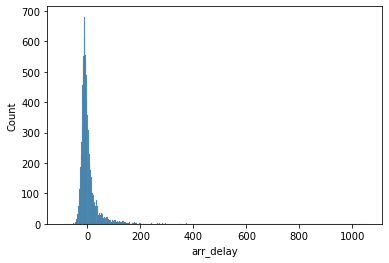

In [10]:
# target variable distribution
# left skewed with long tail
target_train = df_train['arr_delay']
target_test = df_test['arr_delay']
sns.histplot(data=target_train)
plt.show()

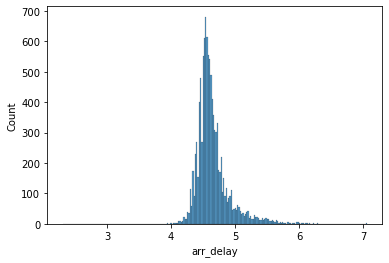

In [11]:
# target variable distribution after log transformation in training set
# If use transformed target variable to train, when evaluate prediction results, REMEMBER to transform predicted value back first
diff = df['arr_delay'].min() - 10 # min value of whole dataset
target_train_log = np.log(target_train - diff)
sns.histplot(data=target_train_log)
plt.show()

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [12]:
# scores = []
# for f in features:
#     X = pd.get_dummies(data=data[['dep_min_sin', 'dep_min_cos', 'fl_month', 'op_unique_carrier', 'inbound_fl_num', 'arr_min_of_day', 'crs_elapsed_time', 'distance', 'fl_weekday', f]], drop_first=True)
#     y = y_log
    
#     X_scaled = scaler.fit_transform(X)
#     y_scaled = scaler.fit_transform(y)

#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, train_size=0.5, test_size=0.3, random_state=88)
    
#     rr = cross_validate(estimator=Ridge(alpha=0.1),
#                         X=X_train,
#                         y=y_train,
#                         cv=5,
#                         scoring='r2',
#                         return_train_score=True)
    
#     scores.append([f, rr['test_score'].mean()])

In [13]:
# score = pd.DataFrame(scores)
# score[score[1]==score[1].max()]

In [14]:
# X = pd.get_dummies(data=data[['dep_min_sin', 'dep_min_cos', 'fl_month', 'op_unique_carrier', 'inbound_fl_num', 'arr_min_of_day', 'crs_elapsed_time', 'distance', 'fl_wkday_sin', 'fl_wkday_cos']], drop_first=True)
# y = y_log
    
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, train_size=0.5, test_size=0.3, random_state=88)
    
# rr = cross_validate(estimator=Ridge(alpha=0.1),
#                         X=X_train,
#                         y=y_train,
#                         cv=5,
#                         scoring='r2',
#                         return_train_score=True)
    
# rr['test_score']
# rr['test_score'].mean()

#### XGBoost

In [15]:
avail_features = [
    # 'fl_date',
    # 'op_unique_carrier',
    # 'tail_num', 
    # 'op_carrier_fl_num',
    # 'origin_airport_id',
    # 'dest_airport_id',
    # 'crs_dep_time',
    # 'crs_arr_time',
    # 'crs_elapsed_time',
    'distance',
    # 'share_code',
    # 'origin_city',
    # 'origin_state',
    # 'dest_city',
    # 'dest_state',
    # 'arr_date',
    # 'dep_datetime',
    # 'arr_datetime',
    # 'fl_month',
    # 'fl_weekday',
    # 'season',
    # 'day_num_of_flights',
    'num_flights_6hr',
    'inbound_fl_num',
    # 'inbound_fl',
    # 'dep_min_of_day',
    # 'arr_min_of_day',
    # 'dep_hr',
    # 'arr_hr',
    'arr_min_sin',
    'arr_min_cos',
    # 'arr_hr_sin',
    # 'arr_hr_cos',
    'dep_min_sin', 
    'dep_min_cos', 
    # 'dep_hr_sin', 
    # 'dep_hr_cos',
    'fl_mnth_sin', 
    'fl_mnth_cos',
    'fl_wkday_sin',
    'fl_wkday_cos',
    'op_unique_carrier_delayct',
    'op_unique_carrier_delaymedian',
    # 'op_unique_carrier_delayavg',
    # 'tail_num_delayct', 
    # 'tail_num_delaymedian',
    'tail_num_delayavg',
    # 'op_carrier_fl_num_delayct',
    # 'op_carrier_fl_num_delaymedian', 
    'op_carrier_fl_num_delayavg',
    'origin_airport_id_delayct', 
    # 'origin_airport_id_delaymedian',
    'origin_airport_id_delayavg',
    'dest_airport_id_delayct',
    # 'dest_airport_id_delaymedian',
    'dest_airport_id_delayavg',
    'origin_city_delayct',
    'origin_city_delaymedian', 
    # 'origin_city_delayavg',
    'origin_state_delayct', 
    'origin_state_delaymedian',
    # 'origin_state_delayavg',
    'dest_city_delayct', 
    'dest_city_delaymedian',
    # 'dest_city_delayavg',
    # 'dest_state_delayct',
    # 'dest_state_delaymedian',
    'dest_state_delayavg'
]

In [28]:
X_train = df_train[avail_features]
# y_train = target_train_log
y_train = target_train
X_test = df_test[avail_features]
y_test = target_test

xg_reg = XGBRegressor(objective ='reg:squarederror',
                      learning_rate = 0.1,
                      max_depth = 6,
                      # reg_lambda = 10,
                      n_estimators = 300)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
# y_pred = np.exp(xg_reg.predict(X_test)) + diff

In [29]:
xg_reg.score(X_train, y_train)

0.9530710560765032

In [30]:
xg_reg.score(X_test, y_test)

0.49758117556661596

In [31]:
## Best Score got so far
r2_score(y_test, y_pred)

0.49758117556661596

##### PCA

In [20]:
pca_features = [
    # 'op_unique_carrier',
    # 'tail_num'.
    # 'op_carrier_fl_num',
    # 'origin_airport_id',
    # 'dest_airport_id',
    'crs_elapsed_time',
    'distance',
    'share_code',
    # 'origin_city',
    # 'origin_state',
    # 'dest_city',
    # 'dest_state',
    'fl_month',
    'fl_weekday',
    'season',
    'day_num_of_flights',
    'num_flights_6hr',
    'inbound_fl_num',
    'inbound_fl',
    'dep_min_of_day',
    'arr_min_of_day',
    'dep_hr',
    'arr_hr',
    'arr_hr_sin',
    'arr_hr_cos',
    'arr_min_sin',
    'arr_min_cos',
    'dep_min_sin',
    'dep_min_cos',
    'dep_hr_sin',
    'dep_hr_cos',
    'fl_mnth_sin',
    'fl_mnth_cos',
    'fl_wkday_sin',
    'fl_wkday_cos',
    'op_unique_carrier_delayct',
    'op_unique_carrier_delaymedian',
    'tail_num_delayct',
    'tail_num_delaymedian',
    'op_carrier_fl_num_delayct',
    'op_carrier_fl_num_delaymedian',
    'origin_airport_id_delayct',
    'origin_airport_id_delaymedian',
    'dest_airport_id_delayct',
    'dest_airport_id_delaymedian',
    'origin_city_delayct',
    'origin_city_delaymedian',
    'origin_state_delayct',
    'origin_state_delaymedian',
    'dest_city_delayct',
    'dest_city_delaymedian',
    'dest_state_delayct',
    'dest_state_delaymedian'
]

In [21]:
df_X = pd.concat([df_train[pca_features], df_test[pca_features]])
df_train.shape[0]

10609

In [25]:
X_scaled = scaler.fit_transform(df_X)

pca = PCA(n_components='mle')
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [26]:
X_scaled_train = X_pca[:10609, :]
X_scaled_test = X_pca[10609:, :]
y_train = target_train_log
y_test = target_test

xg_reg = XGBRegressor(objective ='reg:squarederror',
                      learning_rate = 0.1,
                      max_depth = 6,
                      # reg_lambda = 10,
                      n_estimators = 300)
xg_reg.fit(X_scaled_train, y_train)
# y_pred = xg_reg.predict(X_test)
y_pred = np.exp(xg_reg.predict(X_scaled_test)) + diff

In [27]:
r2_score(y_test, y_pred)

0.11846731863060067

In [43]:
# features = [
#     # 'op_unique_carrier',
#     # 'tail_num'.
#     # 'op_carrier_fl_num',
#     # 'origin_airport_id',
#     # 'dest_airport_id',
#     # 'crs_elapsed_time',
#     'distance',
#     'share_code',
#     # 'origin_city',
#     # 'origin_state',
#     # 'dest_city',
#     # 'dest_state',
#     # 'fl_month',
#     # 'fl_weekday',
#     # 'season',
#     # 'day_num_of_flights',
#     # 'num_flights_6hr',
#     # 'inbound_fl_num',
#     # 'inbound_fl',
#     # 'dep_min_of_day',
#     # 'arr_min_of_day',
#     # 'dep_hr',
#     # 'arr_hr',
#     # 'arr_hr_sin',
#     # 'arr_hr_cos',
#     # 'arr_min_sin',
#     # 'arr_min_cos',
#     'dep_min_sin',
#     # 'dep_min_cos',
#     # 'dep_hr_sin',
#     # 'dep_hr_cos',
#     # 'fl_mnth_sin',
#     # 'fl_mnth_cos',
#     # 'fl_wkday_sin',
#     # 'fl_wkday_cos',
#     # 'op_unique_carrier_delayct',
#     # 'op_unique_carrier_delaymedian',
#     'tail_num_delayct',
#     # 'tail_num_delaymedian',
#     'op_carrier_fl_num_delayct',
#     # 'op_carrier_fl_num_delaymedian',
#     # 'origin_airport_id_delayct',
#     # 'origin_airport_id_delaymedian',
#     # 'dest_airport_id_delayct',
#     # 'dest_airport_id_delaymedian',
#     # 'origin_city_delayct',
#     'origin_city_delaymedian',
#     # 'origin_state_delayct',
#     'origin_state_delaymedian',
#     'dest_city_delayct',
#     # 'dest_city_delaymedian',
#     # 'dest_state_delayct',
#     'dest_state_delaymedian'
# ]

In [44]:
# scores = []
# for f in features:
#     X_train = df_train[[f]]
#     y_train = target_train_log
#     X_test = df_test[[f]]
#     y_test = target_test
    
#     xg_reg = XGBRegressor(objective ='reg:squarederror',
#                       learning_rate = 0.1,
#                       max_depth = 6,
#                       # reg_lambda = 10,
#                       n_estimators = 300)
#     xg_reg.fit(X_train, y_train)
#     y_pred = np.exp(xg_reg.predict(X_test)) + diff
#     # y_pred = xg_reg.predict(X_test)
    
#     scores.append([f, xg_reg.score(X_train, y_train), r2_score(y_test, y_pred)])

In [45]:
# s = pd.DataFrame(scores)
# s[s[2]==s[2].max()]

,0,1,2
5,origin_city_delaymedian,0.824356,0.240021


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.